In [121]:
from __future__ import print_function
import pandas as pd
import numpy as np
import xlsxwriter
import cv2
import matplotlib.colors as cs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import urllib
from pyinaturalist import get_observations
import urllib.request
from matplotlib import pyplot as plt

### Create a new structured dataframe using the user id

In [122]:
iNaturalist_Username = input()

In [123]:
# Create a new observation
observations = get_observations(user_id=iNaturalist_Username, page='all')

# df_list is used to append all the observations into a dataframe
df_list = []
# df_url is used to store image urls
df_url = []
# df_lat_long is used to store latitude and longitude
df_lat = []
df_long = []
# df_site_url is used to store site url
df_site_url = []
# Store user id and login
# df_user_id = []
df_user_login = []
# Store public/positional accuracy
# df_pos_acc = []
# df_pub_pos_acc = []
# Store annotations
df_annotations = []

for obs in observations['results']:
    # From dict to dataframe
    df = pd.DataFrame.from_dict(obs, orient='index')
    # Get image urls
    if obs.get('photos') is not None:
        image_url = obs.get('photos')[0].get('url')
    else:
        image_url = 'None'
    # Get latitude and longitude
    # Get positional accuracy
    if obs.get('location') is not None:
        lat = obs.get('location')[0]
        lon = obs.get('location')[1]
        # pos_acc = obs.get('positional_accuracy')
        # pub_pos_acc = obs.get('public_positional_accuracy')
    else:
        lat = '             40.343137'
        lon = '             74.655070'
    # Get annotations
    if obs.get('annotations') is not None and lat == '             40.343137' and lon == '             74.655070':
        anno = 'Princeton University'
    else:
        anno = obs.get('annotations')
        # pos_acc = 'None'
        # pub_pos_acc = 'None'
    # Get site url
    if obs.get('uri') is not None:
        site_url = obs.get('uri')
    else:
        site_url = 'None'
    # Get user id and login
    if obs.get('user') is not None:
        #user_id = obs.get('user').get('id')
        user_login = obs.get('user').get('login')
    else:
        #user_id = 'None'
        user_login = 'None'
        
    # Transpose the dataframe so that rows represent images and columns are variables
    # that describe the images.
    df = df.transpose()
    df_list.append(df)
    df_url.append(image_url)
    df_lat.append(lat)
    df_long.append(lon)
    df_site_url.append(site_url)
    #df_user_id.append(user_id)
    df_user_login.append(user_login)
    # df_pos_acc.append(pos_acc)
    # df_pub_pos_acc.append(pub_pos_acc)
    df_annotations.append(anno)

# Concatenate all dataframes
iNatStruct = pd.concat(df_list)

# Add updated columns to the dataframe
iNatStruct['square_image_url'] = df_url
iNatStruct['latitude'] = df_lat
iNatStruct['longitude'] = df_long
iNatStruct['site_url'] = df_site_url
#iNatStruct['user_id'] = df_user_id
iNatStruct['User'] = df_user_login
# iNatStruct['positional_accuracy'] = df_pos_acc
# iNatStruct['public_positional_accuracy'] = df_pub_pos_acc
iNatStruct['annotations'] = df_annotations

# Replace image size from 'square' to 'medium' and 'large'
iNatStruct['Image_Link'] = iNatStruct['square_image_url'].replace('square', 'medium', regex=True)
# iNatStruct['large_image_url'] = iNatStruct['square_image_url'].replace('square', 'large', regex=True)

# Reset index and drop the old index
iNatStruct = iNatStruct.reset_index()
# iNatStruct = iNatStruct.drop(['index'], axis=1)

# iNatStruct
# observations['results']

## Continue on initial structured data frame 

In [124]:
# Split time_observed_at into date and time
def convertT(time):
    time = time.replace('T',' ')
    return time

(iNatStruct.time_observed_at.map(lambda t: convertT(t).split()))[0][1]

'09:46:00+00:00'

In [125]:
# Use lambda function to split time_observed_at into date and time
for i in iNatStruct.time_observed_at:    
    iNatStruct['observed_date'] = (iNatStruct.time_observed_at.map(lambda t: convertT(t).split()[0]))
    iNatStruct['observed_time'] = (iNatStruct.time_observed_at.map(lambda t: convertT(t).split()[1]))

In [126]:
# shift columns observed_date and observed_time to position 1 and 2
column1 = iNatStruct.pop('observed_date')
column2 = iNatStruct.pop('observed_time')
  
# insert column using insert
iNatStruct.insert(1, 'observed_date', column1)
iNatStruct.insert(2, 'observed_time', column2)

# delete time_observed_at column
del iNatStruct["time_observed_at"]
del iNatStruct["observed_on"]
#del iNatStruct["observed_time"]

In [127]:
# shift location column to last column
column1 = iNatStruct.pop('location')
  
# insert location column using insert
iNatStruct.insert(len(iNatStruct) - 1, 'location', column1) 
# not sure why it's not moving the column to last position

In [128]:
# Remove the characters after '-'
def removeChar(char):
    ch = "-"
    char = char.split(ch, 1)[0]
    return char

# Use lambda function to remove the characters after '-'
iNatStruct['observed_time'] = iNatStruct.observed_time.map(lambda t: removeChar(t))

In [129]:
# Remove the characters after '+'
def removeChara(char):
    ch = "+"
    char = char.split(ch, 1)[0]
    return char

# Use lambda function to remove the characters after '+'
iNatStruct['observed_time'] = iNatStruct.observed_time.map(lambda t: removeChara(t))

In [130]:
# Time to Second
def timeToSec(time):
    time = time.split(':')
    sec = int(time[0])*3600 + int(time[1])*60 + int(time[2])
    return sec

# Use lambda function to convert time to second
iNatStruct['Seconds'] = iNatStruct.observed_time.map(lambda t: timeToSec(t))

In [131]:
# Rename columns
iNatStruct.rename(columns = {'species_guess':'Species', 'observed_date':'Date', 'observed_time':'Time', 
                             'annotations':'Annotations', 'latitude':'Lat', 'longitude':'Long'}, inplace = True)

# The structured dataframe is now ready
iNatStruct = iNatStruct[["Image_Link", "Species", "User", "Date", "Time", "Seconds", "Annotations", "Lat", "Long"]]

# Add p_ column
p_lab = ['p'+str(s+1) for s in iNatStruct.index]
iNatStruct.insert(0, "Image_Label", p_lab)

# Sort DataFrame by date and time
iNatStruct = iNatStruct.sort_values(['Date', 'Time'], ascending = [True, True])

iNatStruct

,Image_Label,Image_Link,Species,User,Date,Time,Seconds,Annotations,Lat,Long
0,p1,https://inaturalist-open-data.s3.amazonaws.com...,cork oak,leejuju,2012-12-05,09:46:00,35160,[],41.152000,-8.635000
1,p2,https://inaturalist-open-data.s3.amazonaws.com...,Grey Willow,leejuju,2012-12-05,10:01:00,36060,[],41.151833,-8.634833
2,p3,https://inaturalist-open-data.s3.amazonaws.com...,Black Poplar,leejuju,2012-12-05,10:15:00,36900,[],41.152000,-8.635000
4,p5,https://inaturalist-open-data.s3.amazonaws.com...,European Holly,leejuju,2012-12-05,11:03:00,39780,[],41.152000,-8.635000
5,p6,https://inaturalist-open-data.s3.amazonaws.com...,Silver Lime,leejuju,2012-12-05,11:40:00,42000,[],41.152000,-8.635000
3,p4,https://inaturalist-open-data.s3.amazonaws.com...,Maples,leejuju,2012-12-05,12:47:00,46020,[],41.151833,-8.635000
6,p7,https://inaturalist-open-data.s3.amazonaws.com...,Nettle Tree,leejuju,2012-12-05,12:57:00,46620,[],41.152000,-8.635000
7,p8,https://inaturalist-open-data.s3.amazonaws.com...,White Poplar,leejuju,2012-12-05,15:20:00,55200,[],41.152000,-8.635000
8,p9,https://inaturalist-open-data.s3.amazonaws.com...,érable à Giguère,leejuju,2012-12-05,15:38:00,56280,[],41.151833,-8.634833
9,p10,https://inaturalist-open-data.s3.amazonaws.com...,common yew,leejuju,2012-12-05,15:58:00,57480,[],41.010629,-8.751703


# Jubilee's color observation code

## Show percentage of dominant (most frequent) color within image using kmeans

In [132]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, so that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    #hist = "{:.2f}".format(hist)
    
    # return the histogram
    return hist


#hist = centroid_histogram(clt)
#print(hist)
#type(hist)

### Define Color Palette Display Function

In [133]:
def palette(clusters):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_):
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

## Implement RGB color column

In [134]:
# column name list 
col_names =  ['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3']
col_names1 =  ['Per1', 'Per2', 'Per3']
  
# create an empty dataframe
# with columns
RGBdf = pd.DataFrame(columns = col_names)
PERdf = pd.DataFrame(columns = col_names1) 
#RGBdf

In [135]:
#import time

In [136]:
#start = time.time()

#clustNum = 3 #set number of cluster for kmeans to be 3
#clt = KMeans(n_clusters=clustNum) # kmeans to find color cluster

#for img in iNatStruct["Image_Link"]: 
#    req = urllib.request.urlopen(img)
#    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#    imgNat = cv2.imdecode(arr, -1)
#    imgNat = cv2.cvtColor(imgNat,cv2.COLOR_BGR2RGB) #convert bgr to rgb
#    n_img = np.reshape(imgNat,(imgNat.shape[0]*imgNat.shape[1],3)) #reshape img array
#    clt.fit(n_img)
    
    #labels = np.unique(clt.labels_) #get unique value of labels in kmeans
    #hist,_ = np.histogram(clt.labels_,bins=np.arange(len(labels)+1)) #find pixel numbers of each color
    #colors = [] # list to hold color
    #rgbVals = [] 
    #rgbVals1 = [] 
    #hexlabels = [] # list to hold hex color code
#end = time.time()
#elapsedTime = round(end-start,3)
#print("new code block took", elapsedTime)

### attempt to use function

In [137]:
#def imgConvert(img): 
#    for img in iNatStruct["Image_Link"]: 
#        req = urllib.request.urlopen(img)
#        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#        imgNat = cv2.imdecode(arr, -1)
#        imgNat = cv2.cvtColor(imgNat,cv2.COLOR_BGR2RGB) #convert bgr to rgb
#        n_img = np.reshape(imgNat,(imgNat.shape[0]*imgNat.shape[1],3)) #reshape img array
        
#    return clt.fit(n_img)

In [138]:
#start = time.time()
#heights_cm = list(map(imgConvert, iNatStruct["Image_Link"]))
#end = time.time()
#elapsedTime = round(end-start,3)
#print("new code block took", elapsedTime)

In [139]:
#start = time.time()

hex_code = []
r_pix = []
g_pix = []
b_pix = []
per = []

clustNum = 3 #set number of cluster for kmeans to be 3
clt = KMeans(n_clusters=clustNum) # kmeans to find color cluster

for img in iNatStruct["Image_Link"]: 
    req = urllib.request.urlopen(img)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    imgNat = cv2.imdecode(arr, -1)
    #print(img)
    
    #clustNum = 3 #set number of cluster for kmeans to be 3
    #clustNum = 4 #set number of cluster for kmeans to be 4
    imgNat = cv2.cvtColor(imgNat,cv2.COLOR_BGR2RGB) #convert bgr to rgb
    n_img = np.reshape(imgNat,(imgNat.shape[0]*imgNat.shape[1],3)) #reshape img array
    #clt = KMeans(n_clusters=clustNum) # kmeans to find color cluster
    clt.fit(n_img)
    labels = np.unique(clt.labels_) #get unique value of labels in kmeans
    hist,_ = np.histogram(clt.labels_,bins=np.arange(len(labels)+1)) #find pixel numbers of each color
    colors = [] # list to hold color
    rgbVals = [] 
    #rgbVals1 = [] 
    hexlabels = [] # list to hold hex color code
    
    #get the main color
    for i in range(clt.cluster_centers_.shape[0]):
        #colors.append(tuple(clt.cluster_centers_[i]/255))
        colors.append(tuple(clt.cluster_centers_[i]))
        
        # add individual RGB values
        #out = [(clt.cluster_centers_[i][j]) for j in range(clustNum)]
        
        # uncomment
        for j in range(clustNum):
            rgbVals.append(clt.cluster_centers_[i][j])
            
        hexlabels.append(cs.to_hex(tuple(clt.cluster_centers_[i]/255)))

    
    ## uncomment
    rgbVals = [rgbVals]
    
    # add percentage
    #histPer = centroid_histogram(clt)
    #histPer = list(histPer)
    histPer = list(centroid_histogram(clt))
    #histPer = [round(percent,2) for percent in histPer]
    per.append([round(percent,2) for percent in histPer])
    #per.append(histPer)
    
    # append RGB
    RGBdf = RGBdf.append(pd.DataFrame(rgbVals, columns=['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3']), 
                   ignore_index = True)
    
    #iNatStruct["hex_color_code"]
    hex_code.append(hexlabels)
    
    #for idx in range(clustNum):
    #    r_pix.append(clt.cluster_centers_[idx][0]) # R
    #    g_pix.append(clt.cluster_centers_[idx][1]) # G
    #    b_pix.append(clt.cluster_centers_[idx][2]) # G
    #r_pix.append(clt.cluster_centers_[0]) # R
    #g_pix.append(clt.cluster_centers_[1]) # G
    #b_pix.append(clt.cluster_centers_[2]) # B
#end = time.time()
#elapsedTime = round(end-start,3)
#print("new code block took", elapsedTime)    

C:\Users\18334\AppData\Local\Temp\ipykernel_13148\4271983686.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RGBdf = RGBdf.append(pd.DataFrame(rgbVals, columns=['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3']),
C:\Users\18334\AppData\Local\Temp\ipykernel_13148\4271983686.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RGBdf = RGBdf.append(pd.DataFrame(rgbVals, columns=['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3']),
C:\Users\18334\AppData\Local\Temp\ipykernel_13148\4271983686.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RGBdf = RGBdf.append(pd.DataFrame(rgbVals, columns=['R1', 'G1', 'B1', 'R2', 'G2', 'B2', 'R3', 'G3', 'B3']),
C:\Users\18334\AppData\Local\Temp\ipykernel_13148\4271983686.py:58:

In [140]:
#rgbVals

In [141]:
#print(type(colors))
#colors
#colors[0]

In [142]:
#newCol = [colors]
#newCol[0]

In [143]:
#print(per[0])
#per

In [144]:
# column name list 
#col_names2 =  ['R', 'G', 'B']
  
# create an empty dataframe
#df = pd.DataFrame(columns = col_names2) 

In [145]:
# example column
#for i in range(len(df)):
#    df.loc[i] = colors[i]
#df.head()

In [146]:
# percent column
for i in range(len(per)):
    PERdf.loc[i] = per[i]
PERdf.head()

,Per1,Per2,Per3
0,0.37,0.14,0.49
1,0.42,0.11,0.47
2,0.46,0.08,0.46
3,0.33,0.12,0.54
4,0.15,0.70,0.14


In [147]:
# re-set index to be same as iNatStruct
RGBdf = RGBdf.set_index(iNatStruct.index)
PERdf = PERdf.set_index(iNatStruct.index)

In [148]:
# append method
#result = iNatStruct.append(RGBdf)
result = pd.concat([iNatStruct, RGBdf, PERdf], axis=1)
#display(result)

In [149]:
iNatStruct = result
#iNatStruct["Percentage"] = per
iNatStruct["Hex_Color_Code"] = hex_code
#iNatStruct.head()

In [150]:
#hist = centroid_histogram(clt)
#maxPer = max(hist)
#maxPer

In [151]:
#plt.imshow(imgNat)

In [152]:
#plt.pie(hist,labels=hexlabels,colors=colors,autopct='%1.1f%%')
#plt.axis('equal')
#plt.show()

### masking attempt

In [153]:
# attempt on p9
#req = urllib.request.urlopen(iNatStruct["Image_Link"][0])
#arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#imgNat = cv2.imdecode(arr, -1)
#imgray = cv2.cvtColor(imgNat, cv2.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(imgray, (5,5), 0)
#thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(imgNat, contours, -1, (0, 255, 0), 3)
#plt.imshow(imgNat)

In [154]:
# Attempt on image with background of clear white
#image6 = cv2.imread('/Users/jubls/Documents/AndroVTURCS/leaf_white.jpeg')
#blurred = cv2.blur(imgNat, (3,3))
#canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
#pts = np.argwhere(canny>0)
#y1,x1 = pts.min(axis=0)
#y2,x2 = pts.max(axis=0)

## crop the region
#cropped = imgNat[y1:y2, x1:x2]
#cv2.imwrite("cropped.png", cropped)

#tagged = cv2.rectangle(imgNat.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
#cv2.imshow("tagged", tagged)
#cv2.waitKey()

In [155]:
# create zero matrix 
#mask = np.zeros(imgNat.shape[:2], dtype="uint8")
#cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)
#cv2.imshow("Rectangular Mask", mask)

# apply our mask: notice the leaf in image is cropped out
#masked = cv2.bitwise_and(imgNat, imgNat, mask=mask)
#masked = cv2.bitwise_not(imgNat, imgNat, mask=mask)
#cv2.imshow("Mask Applied to Leaf Image", masked)
#cv2.waitKey(0)

In [156]:
#print(imgNat.shape)
#print((x2, y2))
#print((x1, y1))
#print(imgNat.shape[:2])
#print(imgNat.shape[1])

## First Method in attempt to mask out background¶
- un-comment to check

In [157]:
#cropped_image = imgNat[y2:imgNat.shape[0], x2:imgNat.shape[1]]
#cv2.imshow("Mask Applied to Leaf Image", cropped_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [158]:
#arr = np.asarray(bytearray(cropped_image.read()), dtype=np.uint8)
#imgNat = cv2.imdecode(arr, -1)
#clustNum = 1 #set number of cluster for kmeans to be 2
#n_img = np.reshape(cropped_image,(cropped_image.shape[0]*cropped_image.shape[1],3)) #reshape img array
#clt = KMeans(n_clusters=clustNum) # kmeans to find color cluster
#clt.fit(n_img)
#labels = np.unique(clt.labels_) #get unique value of labels in kmeans
#hist,_ = np.histogram(clt.labels_,bins=np.arange(len(labels)+1)) #find pixel numbers of each color
#colors = [] # list to hold color
#hexlabels = [] # list to hold hex color code
#col_pix = []

#get the main color
#for i in range(clt.cluster_centers_.shape[0]):
    #clust_cent = tuple(clt.cluster_centers_[i]/255)
#    colors.append(tuple(clt.cluster_centers_[i]/255))
#    col_pix.append(tuple(clt.cluster_centers_[i]))
    #colors.append(clust_cent)
#    hexlabels.append(cs.to_hex(tuple(clt.cluster_centers_[i]/255)))
    

#### create pie chart for color

In [159]:
#plt.pie(hist,labels=hexlabels,colors=colors,autopct='%1.1f%%')
#plt.axis('equal')
#plt.show()

## Second Method in attempt to mask out background

In [160]:
#img = cv.imread('test2.jpg')
#imgray = cv2.cvtColor(imgNat, cv2.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(imgray, (5,5), 0)
#thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(imgNat, contours, -1, (0, 255, 0), 3)
#plt.imshow(imgNat)

In [161]:
#arr = np.asarray(bytearray(cropped_image.read()), dtype=np.uint8)
#imgNat = cv2.imdecode(arr, -1)
#clustNum = 4 #set number of cluster for kmeans to be 4
#n_img = np.reshape(imgNat,(imgNat.shape[0]*imgNat.shape[1],3)) #reshape img array
#clt = KMeans(n_clusters=clustNum) # kmeans to find color cluster
#clt.fit(n_img)
#labels = np.unique(clt.labels_) #get unique value of labels in kmeans
#hist,_ = np.histogram(clt.labels_,bins=np.arange(len(labels)+1)) #find pixel numbers of each color
#colors = [] # list to hold color
#hexlabels = [] # list to hold hex color code
#col_pix = []

#get the main color
#for i in range(clt.cluster_centers_.shape[0]):
    #clust_cent = tuple(clt.cluster_centers_[i]/255)
#    colors.append(tuple(clt.cluster_centers_[i]/255))
#    col_pix.append(tuple(clt.cluster_centers_[i]))
    #colors.append(clust_cent)
    #hexlabels.append(cs.to_hex(tuple(clt.cluster_centers_[i]/255)))
    

In [162]:
#from pylab import *
#clt = clt.fit(imgNat.reshape(-1, 3))
#imshow(palette(clt))

# Wei's code

In [163]:
# Wei's new first block of code
#img = cv.imread('test2.jpg')
#imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(imgray, (5,5), 0)
#thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [164]:
def tag(img):
    blurred = cv2.blur(imgNat, (3,3))
    canny = cv2.Canny(blurred, 50, 200)
    
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    
    w = (x2-x1) # width
    h = (y2-y1) # height
    
    return [w,h]

In [165]:
print(tag(imgNat))
print(tag(imgNat)[0])
print(tag(imgNat)[1])

[122, 412]
122
412


In [166]:
ex = [tag(imgNat),tag(imgNat)]
np.array(tag(imgNat))
np.array(ex)

array([[122, 412],
       [122, 412]], dtype=int64)

In [167]:
#start = time.time()

contArea = []
width = []
height = []
ratio = []
extentInfo = []
solidityInfo = []
angleInfo = []

#for img in iNatStruct.index: 
for img in iNatStruct["Image_Link"]: 
    req = urllib.request.urlopen(img)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    imgNat = cv2.imdecode(arr, -1)
    #print(img)
    
    #img = cv2.imread('test2.jpg')
    imgray = cv2.cvtColor(imgNat, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(imgray, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(imgNat, contours, -1, (0, 255, 0), 3)
    
    #plt.imshow(imgNat)
    
    # Contour Area
    #cnt = contours[1] >> throws an error for some reason..?
    cnt = contours[0] # this works

    
    # rotated rectangle
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    x,y,w,h = cv2.boundingRect(box)
    #cv2.drawContours(img,[box],0,(0,0,255),2)
    
    #aspect_ratio = float(w1)/h1
    #print(aspect_ratio)
    
    area = cv2.contourArea(cnt)
    #print(area)
    
    if area < 50:
        w = tag(imgNat)[0]
        h = tag(imgNat)[1]
        cnt = np.array([tag(imgNat),tag(imgNat)])
        area = w*h
        #area = cv2.contourArea(cnt)
    
    # aspect_ratio
    #aspect_ratio = float(w1)/h1
    aspect_ratio = float(w)/h
    
    # Extent
    x1,y1,w1,h1 = cv2.boundingRect(cnt) # what is the difference?
    rect_area = w1*h1
    extent = float(area)/rect_area
    #print("the extent is", extent)

    # Solidity
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    #print("the convex hull area is", hull_area)
    #solidity = float(area)/hull_area
    if hull_area == 0:
        solidity = 0
    else:
        solidity = float(area)/hull_area
    #print("the solidity is", solidity)

    # Orientation
    #(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
    #print("the angle of object is", angle)
        
    contArea.append(area)
    width.append(w)
    height.append(h)
    ratio.append(aspect_ratio)
    extentInfo.append(extent)
    solidityInfo.append(solidity)
    #angleInfo.append(angle)
#end = time.time()
#elapsedTime = round(end-start,3)
#print("new code block took", elapsedTime) 

In [168]:
iNatStruct["Contour_Area"] = contArea
iNatStruct["Width"] = width
iNatStruct["Height"] = height
iNatStruct["Aspect_Ratio"] = ratio
iNatStruct["Extent"] = extentInfo
iNatStruct["Solidity"] = solidityInfo
#iNatStruct["angle"] = angleInfo
iNatStruct

,Image_Label,Image_Link,Species,User,Date,Time,Seconds,Annotations,Lat,Long,...,Per1,Per2,Per3,Hex_Color_Code,Contour_Area,Width,Height,Aspect_Ratio,Extent,Solidity
0,p1,https://inaturalist-open-data.s3.amazonaws.com...,cork oak,leejuju,2012-12-05,09:46:00,35160,[],41.152000,-8.635000,...,0.37,0.14,0.49,"[#fd7dc2, #6a5a53, #eb598e]",146982.0,374,393,0.951654,146982.000000,0.0000
1,p2,https://inaturalist-open-data.s3.amazonaws.com...,Grey Willow,leejuju,2012-12-05,10:01:00,36060,[],41.151833,-8.634833,...,0.42,0.11,0.47,"[#fd7dae, #584839, #f75e86]",19935.0,104,302,0.344371,0.668982,0.9661
2,p3,https://inaturalist-open-data.s3.amazonaws.com...,Black Poplar,leejuju,2012-12-05,10:15:00,36900,[],41.152000,-8.635000,...,0.46,0.08,0.46,"[#f86ca0, #7f6a50, #ec5787]",99015.0,287,345,0.831884,99015.000000,0.0000
4,p5,https://inaturalist-open-data.s3.amazonaws.com...,European Holly,leejuju,2012-12-05,11:03:00,39780,[],41.152000,-8.635000,...,0.33,0.12,0.54,"[#ea5c78, #624436, #fd7996]",43920.0,144,305,0.472131,43920.000000,0.0000
5,p6,https://inaturalist-open-data.s3.amazonaws.com...,Silver Lime,leejuju,2012-12-05,11:40:00,42000,[],41.152000,-8.635000,...,0.15,0.70,0.14,"[#9e6f60, #dc6397, #bba27e]",165668.0,332,499,0.665331,165668.000000,0.0000
3,p4,https://inaturalist-open-data.s3.amazonaws.com...,Maples,leejuju,2012-12-05,12:47:00,46020,[],41.151833,-8.635000,...,0.47,0.43,0.09,"[#918f8d, #b5b1ae, #953330]",155958.0,374,417,0.896882,155958.000000,0.0000
6,p7,https://inaturalist-open-data.s3.amazonaws.com...,Nettle Tree,leejuju,2012-12-05,12:57:00,46620,[],41.152000,-8.635000,...,0.15,0.46,0.39,"[#684e4b, #fc7eb1, #ea5d8b]",109962.0,246,447,0.550336,109962.000000,0.0000
7,p8,https://inaturalist-open-data.s3.amazonaws.com...,White Poplar,leejuju,2012-12-05,15:20:00,55200,[],41.152000,-8.635000,...,0.41,0.20,0.39,"[#e5748b, #6a5746, #fc91ae]",98968.0,278,356,0.780899,98968.000000,0.0000
8,p9,https://inaturalist-open-data.s3.amazonaws.com...,érable à Giguère,leejuju,2012-12-05,15:38:00,56280,[],41.151833,-8.634833,...,0.47,0.41,0.12,"[#d75c79, #ec7997, #997c4c]",145112.0,374,388,0.963918,145112.000000,0.0000
9,p10,https://inaturalist-open-data.s3.amazonaws.com...,common yew,leejuju,2012-12-05,15:58:00,57480,[],41.010629,-8.751703,...,0.44,0.18,0.38,"[#f46a80, #574930, #fd859e]",111633.0,293,381,0.769029,111633.000000,0.0000


<matplotlib.image.AxesImage object at 0x0000018855F05810>

<Figure size 432x288 with 1 Axes>

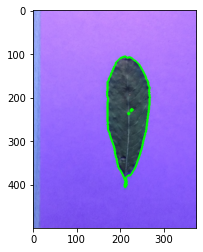

In [169]:
# attempt on p1
req = urllib.request.urlopen(iNatStruct["Image_Link"][1])
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
imgNat = cv2.imdecode(arr, -1)
imgray = cv2.cvtColor(imgNat, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(imgray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgNat, contours, -1, (0, 255, 0), 3)
plt.imshow(imgNat)

In [170]:
cnt = contours[0] # this works
    
# rotated rectangle
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
x1,y1,w1,h1 = cv2.boundingRect(box)
    #cv2.drawContours(img,[box],0,(0,0,255),2)
    
aspect_ratio = float(w1)/h1

In [171]:
aspect_ratio

0.3443708609271523

In [172]:
103/304

0.33881578947368424

In [173]:
tag(imgNat)

[103, 304]

In [174]:
x1,y1,w1,h1 = cv2.boundingRect(cnt)

In [175]:
float(w1)/h1

0.3289036544850498

In [176]:
#plt.imshow(imgNat)

In [177]:
# Attempt on image with background of clear white
#image6 = cv2.imread('/Users/jubls/Documents/AndroVTURCS/leaf_white.jpeg')
#blurred = cv2.blur(imgNat, (3,3))
#canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
#pts = np.argwhere(canny>0)
#y1,x1 = pts.min(axis=0)
#y2,x2 = pts.max(axis=0)

## crop the region
#cropped = imgNat[y1:y2, x1:x2]
#cv2.imwrite("cropped.png", cropped)

#tagged = cv2.rectangle(imgNat.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
#cv2.imshow("tagged", tagged)
#cv2.waitKey()

#print(x2-x1)
#print(y2-y1)

In [178]:
#iNatStruct.to_excel(pd.ExcelWriter, sheet_name='Sheet1', na_rep='', 
#                   float_format=None, columns=None, header=True, index=True, 
#                   index_label=None, startrow=0, startcol=0, engine=None, 
#                   merge_cells=True, encoding=None, inf_rep='inf', verbose=True, 
#                   freeze_panes=None, storage_options=None)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('iNatStruct.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
iNatStruct.to_excel(writer, sheet_name='Sheet1', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [179]:
# convert to csv file
iNatStruct.to_csv('iNatStruct.csv')

In [180]:
# %load_ext watermark
# %watermark -v -m -p pandas,numpy,opencv-python,future,matplotlib,sklearn,urllib3,pyinaturalist,urllib.request,cv2